In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from optimization import *
torch.set_default_dtype(torch.float64)
from PROGRAMS.data_generating_process import *
from PROGRAMS.likelihood import *
from PROGRAMS.programs import *
from PROGRAMS.run_pyro import *
import time

import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']


In [9]:
def neg_log_likelihood(data, dist, idx):
    log_likelihood = torch.log(dist.gm.marg_pdf(data, idx))
    return - torch.sum(log_likelihood)

def run_optimization(name, data, params_init, true_params, eps, sensitivity_analysis=False):
    soga_code = get_program(name)
    compiledFile = compile2SOGA_text(soga_code)
    cfg = produce_cfg_text(compiledFile)
    smooth_cfg(cfg, smooth_eps=eps)

    params_dict = initialize_params(params_init)  
    output_dist = start_SOGA(cfg, params_dict)
    data_var_list = get_vars(name)
    data_var_index = [output_dist.var_list.index(var) for var in data_var_list]
    data = torch.tensor(data, dtype=torch.float64)
    loss = lambda dist : neg_log_likelihood(data, dist, data_var_index)

    loss_list = optimize(cfg, params_dict, loss, n_steps=50, lr=0.05)

    if sensitivity_analysis:
        error_list = []
        #use the average error
        avg_error = np.mean([abs(params_dict[key].item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
        error_list.append(avg_error)
        return error_list

    # print results:
    for key, value in params_dict.items():
        print(f"{key}: {value.item()}")
    
    # get the true value of the parameters from true_params and compute the relative error
    for key, true_value in true_params.items():
        estimated_value = params_dict[key].item()
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

    #calculate average error
    avg_error = np.mean([abs(params_dict[key].item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
    print(f"Average error: {avg_error}")
    
    #save losses to a file
    with open(f'losses_csv/loss_{name}.txt', 'w') as f:
        for loss in loss_list:
            f.write(f"{loss}\n")
    # plot the loss
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.title(f'Loss over iterations for {name}')
    plt.show()


In [10]:
program = 'clickgraph'
data_size = 1000
true_params, init_params = get_params(program)
data = generate_dataset(program, data_size, true_params)

p: 0.5499999999770729  loss: -10622.720695848353
p: 0.7970366227058315  loss: -10628.043737320537
p: 0.9133019278092743  loss: -10627.334488619734
p: 0.8770807693184528  loss: -10627.494701876747
p: 0.7768828675203482  loss: -10628.243813793324
p: 0.7442432699926329  loss: -10627.942963476553
p: 0.8003555509897538  loss: -10628.243313434974
p: 0.8248284485274938  loss: -10628.138372281392
p: 0.7925333415817879  loss: -10628.238907343562
p: 0.7740958124042847  loss: -10628.20631948082
Optimization performed in  5.309
p: 0.7905624919657787
Error in p: 0.011796885042776734
Average error: 0.011796885042776734


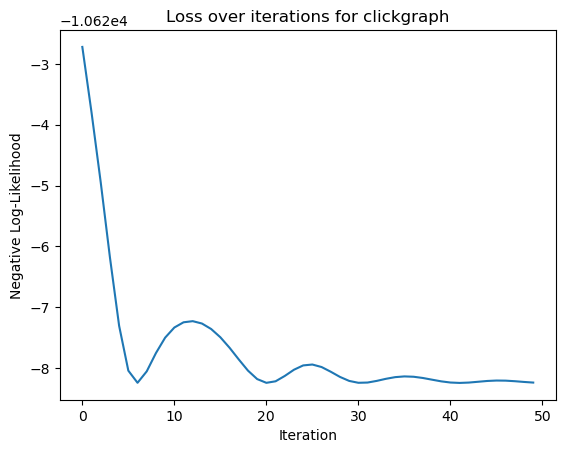

In [11]:
run_optimization(program, data, init_params, true_params, eps=0.001)

Running optimization for eps=0.1
p: 0.4999999671516201  loss: -1410.944399270712
p: 0.49999972669166376  loss: -1410.944399270712
p: 0.49999946161729564  loss: -1410.944399270712
p: 0.4999992063007121  loss: -1410.944399270712
p: 0.49999892945367025  loss: -1410.944399270712
p: 0.4999986428975264  loss: -1410.944399270712
p: 0.49999836642867784  loss: -1410.944399270712
p: 0.4999980960309336  loss: -1410.944399270712
p: 0.499997817183314  loss: -1410.944399270712
p: 0.49999753767754507  loss: -1410.944399270712
Optimization performed in  7.609
Running optimization for eps=0.01
p: 0.5499999999728612  loss: -6014.846710840092
p: 0.8412280369181057  loss: -6017.945746005263
p: 0.7098376018611049  loss: -6018.489540314873
p: 0.7859107391258572  loss: -6018.674245795507
p: 0.7427633755494883  loss: -6018.745081763647
p: 0.7629473823025604  loss: -6018.774245662667
p: 0.7585144571877285  loss: -6018.782751196717
p: 0.7544188191094325  loss: -6018.782551939275
p: 0.7598470330314563  loss: -60

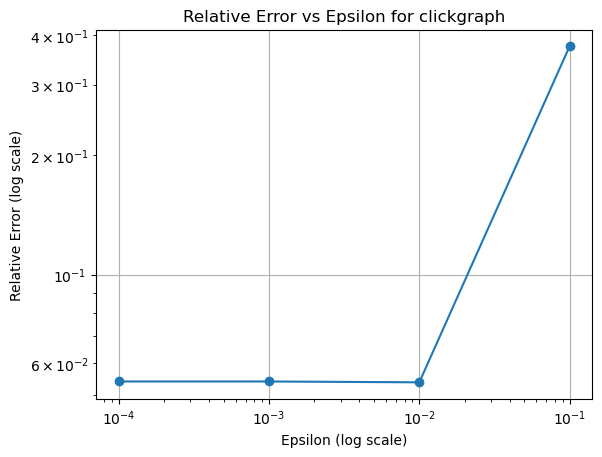

Epsilon: 0.1, Error: [0.375003417802464]
Epsilon: 0.01, Error: [0.053652294495335345]
Epsilon: 0.001, Error: [0.053915528499134946]
Epsilon: 0.0001, Error: [0.05391816810429412]


In [5]:
error_list = []
for eps in [0.1, 0.01, 0.001, 0.0001]:
    print(f"Running optimization for eps={eps}")
    error = run_optimization(program, data, init_params, true_params, eps=eps, sensitivity_analysis=True)
    error_list.append(error)

# plot the error as a function of eps
eps_values = [0.1, 0.01, 0.001, 0.0001]
plt.plot(eps_values, error_list, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epsilon (log scale)')
plt.ylabel('Relative Error (log scale)')
plt.title(f'Relative Error vs Epsilon for {program}')
plt.grid(True)
plt.show()

#print the error values
for eps, error in zip(eps_values, error_list):
    print(f"Epsilon: {eps}, Error: {error}")

#save errors to a file
with open(f'errors_csv/errors_{program}.txt', 'w') as f:
    for eps, error in zip(eps_values, error_list):
        f.write(f"{eps},{error[0]}\n")

## variational inference


In [6]:
model, guide = get_model_guide(program)
run_inference(model, guide, model_params=(data_size,torch.tensor(data, dtype=torch.float64)), n_steps=1000, lr=0.05)
for pyro_param in pyro.get_param_store().get_all_param_names():
    print(f"{pyro_param}: {pyro.param(pyro_param).item()}")

for key, true_value in true_params.items():
        estimated_value = pyro.param(key + "_map").item()
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

avg_error = np.mean([abs(pyro.param(key + "_map").item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
print(f"Average error: {avg_error}")

Step 0 : loss = 2654.4950331645123
Step 100 : loss = 2662.658918624751
Step 200 : loss = 2761.5479282441715


/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'sim', 'beta2_diff', 'beta1'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


Step 300 : loss = 2599.063264039059
Step 400 : loss = 2605.142927346548
Step 500 : loss = 2511.9061207007708
Step 600 : loss = 2389.1843775358716
Step 700 : loss = 2464.410858649084
Step 800 : loss = 2500.5636182421204
Step 900 : loss = 2587.862137658891
Inference performed in  0.843
p_map: 0.6343729363439861
Error in p: 0.20703382957001748
Average error: 0.20703382957001748


## MCMC

In [8]:
# Do the same with MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
# Measure total runtime
start = time.time()
mcmc.run((data_size, torch.tensor(data, dtype=torch.float64)))
end = time.time()

# Get total time
total_time = end - start
print(f"Total MCMC runtime: {total_time:.3f} seconds")
mcmc.summary()
samples = mcmc.get_samples()
for key, true_value in true_params.items():
        estimated_value = torch.mean(samples[key])
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

avg_error = np.mean([abs(torch.mean(samples[key]) - true_value)/abs(true_value) for key, true_value in true_params.items()])
print(f"Average error: {avg_error}")

Sample: 100%|██████████| 1200/1200 [01:06, 18.01it/s, step size=2.07e-01, acc. prob=0.817]


Total MCMC runtime: 66.659 seconds

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1[0]      0.26      0.21      0.22      0.00      0.57    977.99      1.00
       beta1[1]      0.55      0.25      0.55      0.20      0.97   2602.14      1.00
       beta1[2]      0.55      0.24      0.56      0.21      0.98   1581.60      1.00
       beta1[3]      0.73      0.20      0.78      0.44      1.00   1480.89      1.00
       beta1[4]      0.74      0.21      0.78      0.43      1.00   1729.82      1.00
       beta1[5]      0.27      0.22      0.21      0.00      0.60   2565.43      1.00
       beta1[6]      0.27      0.20      0.22      0.00      0.58   1959.84      1.00
       beta1[7]      0.27      0.21      0.22      0.00      0.57   1289.74      1.00
       beta1[8]      0.74      0.20      0.78      0.44      1.00   1967.20      1.00
       beta1[9]      0.45      0.24      0.45      0.01      0.78   1867.37      1.00
      beta1[10]   